# Solution to the Unicef Data Engineer assignment

### TASKS / TODO's and estimation (T-Shirt sizes)
1. Download the Ookla data from Ookla’s S3 bucket - for the most recent 12 months (4 quarters) - Effort: M
    1. Combine the quarterly data into a sensible average (Sum of # devices, Mean of upload / download speeds)
2. Download the most recent Worldpop population data from HDX (Preferably using the HDX API) - Effort: M
    1. Sum the total school age population (5-20yrs old) for each school polygon
3. Merge this data with the existing school polygons geojson - Effort: S
4. Write all this to a new geojson file that [Data Visualisation Specialist] can visualise - Effort: S


#### Notes
- First I want to explore the datasets that I need to use. I want to know what format they are in, how I can access them and what their sizes are. Therefore I immediately install the `geowrangler` library for Python and try to access the Ookla data.
- I also download TIF files from the Humanitarian Data Exchange.
- I also set up a virtual environment locally, so that I can easily manage the desired python version and libraries

## How to run this Notebook

### Python version used:
- Python 3.9.10

### Install python dependencies from `requirements.txt` file:
```pip install -r requirements.txt```

In [ ]:
# Load and explore the schools_by_district data
import geopandas as gpd

df_schools = gpd.read_file("schools_by_district.geojson")
df_schools.head(10)

In [ ]:
# Explore Ookla datasets

# importing ookla from geowrangler
from geowrangler.datasets import ookla

# checking which methods and properties this library contains
print(dir(ookla))

# listing the available dataset files
ookla_datasets = ookla.list_ookla_files()
print(ookla_datasets)

In [ ]:
# Process ookla data

# We want to use dask for its batch processing capabilities for large data
import dask.dataframe as dd

# we want to download the last 4 quarters, that we explored above
ookla_quarter_params = [
    dict(year="2021", quarter="4", directory="data"),
    dict(year="2022", quarter="1", directory="data"),
    dict(year="2022", quarter="2", directory="data"),
    dict(year="2022", quarter="3", directory="data")
]

all_data_ookla = None
for quarter_params in ookla_quarter_params:
    data_ookla = ookla.download_ookla_file(type_="fixed", **quarter_params)
    data_ookla = dd.read_parquet(data_ookla, engine='pyarrow')
    data_ookla = data_ookla.drop(columns=["avg_lat_ms", "tests"])

    if all_data_ookla is not None:
        all_data_ookla = dd.concat([all_data_ookla, data_ookla])
    else:
        all_data_ookla = data_ookla

all_data_ookla = all_data_ookla.groupby(["quadkey", "tile"]).agg({"avg_d_kbps": ['mean'], "avg_u_kbps": ["mean"], "devices": ["sum"]}).compute()
all_data_ookla = all_data_ookla.droplevel(axis=1, level=1).reset_index()

# Now I want to turn the "all_data_ookla" into a GeoPandas dataframe, using "tile" as the geometry.
# Here I kept getting some strange TypeError, and I spent long time figuring out the issue
# TypeError: Input must be valid geometry objects: POLYGON((-160.037841796875 70.6363054807905, -160.032348632812 70.6363054807905, -160.032348632812 70.6344840663086, -160.037841796875 70.6344840663086, -160.037841796875 70.6363054807905))

# Solution
all_data_ookla['geometry'] = gpd.GeoSeries.from_wkt(all_data_ookla['tile'])
all_data_ookla = gpd.GeoDataFrame(all_data_ookla)
all_data_ookla.crs = "EPSG:4326"



In [ ]:
# Join the internet speed data on the school catchment
all_data_ookla_joined = all_data_ookla.sjoin(df_schools)

# Group by school and compute the average upload/download speeds (catchment_average_download_mbps, catchment_average_upload_mbps)
all_data_ookla_joined = all_data_ookla_joined.groupby(["school_id", "lat", "lon", "Shape_Leng", "Shape_Area"]).agg({"avg_d_kbps": ['mean'], "avg_u_kbps": ["mean"], "devices": ["sum"]})
all_data_ookla_joined = all_data_ookla_joined.droplevel(axis=1, level=1).reset_index()

# Next step related to these fields is to save a new geojson file including these school catchment internet speeds

# For the metrics: "school_has_connectivity", "school_download_mbps" and "school_upload_mbps". I am currently not sure how to calculate them.
# This is my only idea: Use lat/lon cordinates (Point) of the schools + shape_leng/area to establish a polygon for each school
# Then check if there are any internet speed tests inside these school polygons
# If there are speed tests inside, then compute the average and set "school_has_connectivity" to True, otherwise False.

school_points = gpd.GeoDataFrame(df_schools[["school_id"]], geometry=gpd.points_from_xy(df_schools.lon, df_schools.lat))
# ... 


### School catchment children

In this part we are gonna use population images of Thailand, downloaded from The Humanitarian Data Exchange.
I was looking for access to a REST API so that I can use the python `requests` library. But I couldnt see any such API documentation for this, only a Python SDK on humdata.org. I decided to just manually download the relevant files directly from the website: https://data.humdata.org/dataset/worldpop-age-and-sex-structures-for-thailand

We wanted data for kids (male/female) aged 5-20 years old. Therefore I set out to download the relevant files such as:
`tha_m_5_2020.tif`, `tha_f_5_2020.tif`, `tha_m_10_2020.tif`, `tha_10_5_2020.tif` etc

I saved these in a data folder and started exploring the data and how to work with it (also completely new to me).

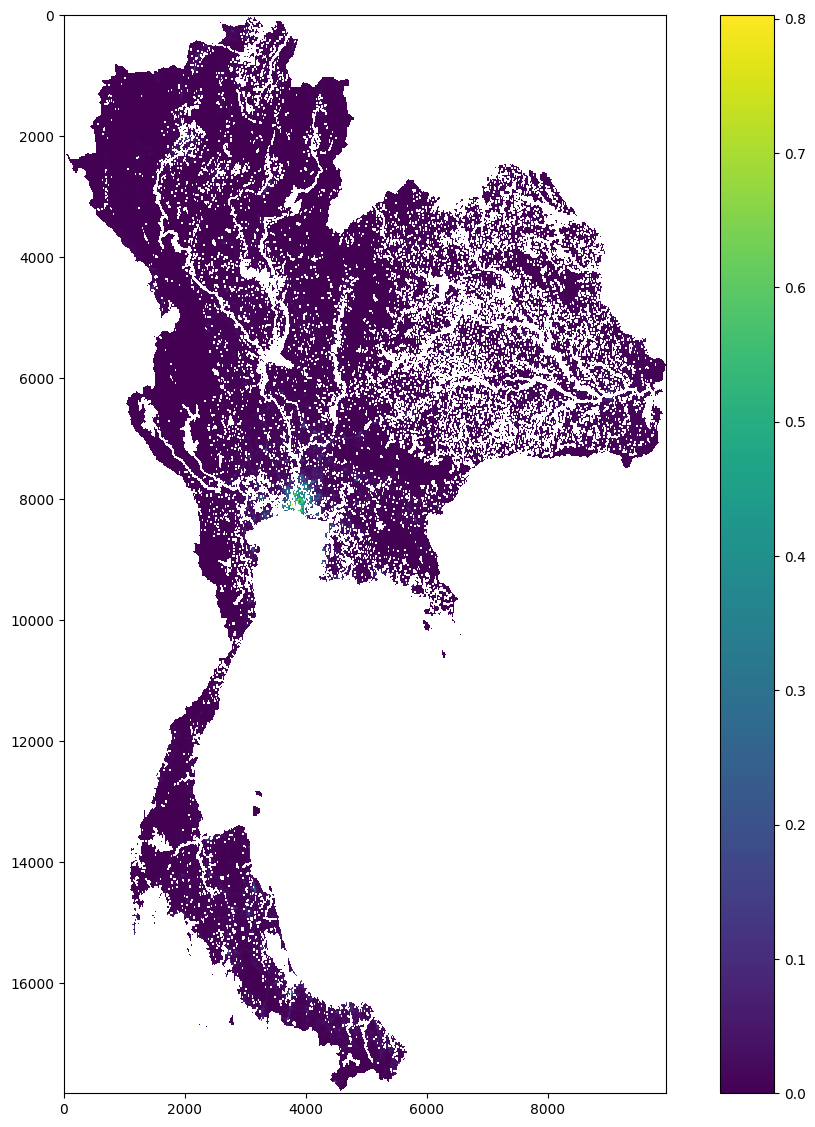

In [6]:
# Explore working with GEOTIF files and plot raster image
import rasterio as rs
import numpy as np
from matplotlib import pyplot as plt

raster_data = rs.open("data/tha_m_5_2020.tif")
raster_data_band = raster_data.read(1)
raster_data_band[raster_data_band < 0] = None

plt.rcParams['figure.figsize'] = 14, 14
plt.imshow(np.log10(raster_data_band+1),)
bar = plt.colorbar()